In [1]:
import os
import sys
import copy as cp
import numpy as np

import seaborn
import pandas

from sklearn.linear_model import LinearRegression
import scipy.stats

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import Patch

In [2]:
sys.path.insert(1, '../code/')

from rank_functions import compute_transformed_Rmat, compute_rho_mat, compute_mean_ranks
from plot_functions import compute_enrichment
from format_helper_functions import make_aa_dict, format_energies_mat_from_df
from mochi_functions import process_mochi

In [3]:
# plotting settings
plt.rcParams.update({'font.size': 8})
plt.rcParams["font.family"] = 'Arial'
rc = {"font.family" : "serif", 
      "mathtext.fontset" : "dejavusans"}
plt.rcParams.update(rc)
plt.rcParams["font.serif"] = ["Arial"] + plt.rcParams["font.serif"]

# color palettes
mypinks    = seaborn.color_palette ('rocket', 10)
myblues    = seaborn.color_palette ('Blues', 10)

In [4]:
# to save plots or not
save = True

# number AA's, positions, total mutations
nAA   = 20
npos  = 55
L     = npos * nAA
xpos  = np.arange (2,npos+2,1)

# observed wild type stats
WT_inp = 1759616
WT_sel = 3041819
y_wt   = WT_sel / WT_inp

# significance threshold
alpha_geom = .1
alpha = 0.1


# for output + input
protein = 'GB1'
mochi_dir = '../results/GB1'
indir     = '../results/GB1/827'

# output directory
outdir  = os.path.join (indir, 'plots')
if not os.path.isdir (outdir) :
    os.makedirs (outdir)    

In [5]:
# aa -> numeric
aadict = make_aa_dict ()

# read in Nisthal energies
ddG      = np.loadtxt ( os.path.join ('../data/GB1', 'ddG_nisthal.csv'))[1:,:]
df_energies = pandas.read_csv ( '../data/GB1/energies.csv')

# wt energies
gf_wt = df_energies['efi'].iloc[0]
gb_wt = df_energies['ebi'].iloc[0]

# map numbers to letters
df_energies['aa_num'] = df_energies['aa'].map (aadict)

# format the estimated energies from otwinowski
energies_singles, energies_mat = format_energies_mat_from_df (df_energies.drop (0), npos,
                                                              ['efi','ebi'], nAA=20, offset=2)

In [6]:
# single + double Y est.
ysing = np.loadtxt ( os.path.join (indir, protein + '_Y_singles.txt'))
ydoub = np.loadtxt ( os.path.join (indir, protein + '_Y_doubles.txt'))

# double reads
n0_doub = np.loadtxt (os.path.join (indir, protein + '_D_neutral.txt'))
n1_doub = np.loadtxt (os.path.join (indir, protein + '_D_selection.txt'))

# single reads
n0_sing = np.loadtxt (os.path.join (indir, protein + '_S_neutral.txt'))
n1_sing = np.loadtxt (os.path.join (indir, protein + '_S_selection.txt'))

# read in all of the results
Pvals = np.loadtxt (os.path.join (indir, protein + '_P.txt'))
#Rmat  =  np.loadtxt (os.path.join (indir, protein + '_Rmat.txt'))
Dmat  =  np.loadtxt (os.path.join (indir, protein + '_Dmat.txt'))

# distance matrix
Dist = np.loadtxt (os.path.join ('../data/', protein, protein + '_distance_matrix.txt'))
# subset distance matrix
Df = cp.deepcopy (Dist[1:,1:])

In [7]:
mochi_fnames = [os.path.join (mochi_dir, 'mochi_three_state.txt'), os.path.join (mochi_dir, 'mochi_two_state.txt')]
mochi_files  = [ pandas.read_csv (x, delimiter='\t', low_memory=False) for x in mochi_fnames ]

mochi_pvals     = np.zeros ((2, L, L))
mochi_residuals = np.zeros ((2, L, L))
mochi_Yd        = np.zeros ((2, L, L))
mochi_Yest      = np.zeros_like (mochi_Yd)
for i in range (2) :
    mochi_pvals[i,:,:], mochi_residuals[i,:,:], mochi_Yd[i,:,:], mochi_Yest[i,:,:] = process_mochi ( mochi_files[i], nmuts=L)

0.9501571119130903
0.9363865139159513


In [8]:
# indices of wt and not wt
wt     = np.array ([x for x in range (L) if np.isnan (ysing[x])], dtype=int)
not_wt = np.array ([x for x in range (L) if ~np.isnan (ysing[x])], dtype=int)
wtseq  = ('').join ([ list (aadict.keys ())[wt[i]-i*nAA] for i in range (npos)])
print (wtseq)

# set -1 values to missing in read counts
n1_doub[n1_doub == -1] = np.nan
n0_doub[n0_doub == -1] = np.nan

# calculate fitness without pseudo-counts
y_doub = (n1_doub) / (n0_doub)

QYKLILNGKTLKGETTTEAVDAATAEKVFKQYANDNGVDGEWTYDDATKTFTVTE


In [9]:
# compute false positive rates and accuracy for mochi over a range of alphas
fdr_alpha = .01
alphas   = np.logspace (-100,-1,50)
accuracy = np.zeros ( (2, len (alphas), 2))
prop     = np.zeros ( (2, len (alphas), 2))

for i in range (2) :    
    pvals_i = cp.deepcopy (mochi_pvals[i,:,:])
    ct = 0
    for a in alphas :
        E_a, T_a = compute_enrichment (pvals_i, alpha=a, nAA=nAA, symmetric=True)

        # fdr p-values and threshold
        fp_a    = scipy.stats.false_discovery_control (E_a[np.triu_indices (npos, k=1)], method='bh')
        fpthres = np.nanmax (E_a[np.triu_indices (npos, k=1)][fp_a < fdr_alpha])

        # compute accuracy at the fp threshold
        accuracy[i,ct,0] = np.sum (np.logical_and (E_a < fpthres, Df <= 5)) / np.sum (E_a < fpthres)
        prop[i,ct,0]     = (np.sum (np.logical_and (E_a < fpthres, Df <= 5)) / np.sum (Df <= 5))

        accuracy[i,ct,1] = np.sum (np.logical_and (E_a < fpthres, Df <= 8)) / np.sum (E_a < fpthres)
        prop[i,ct,1]     = (np.sum (np.logical_and (E_a < fpthres, Df <= 8)) / np.sum (Df <= 8))
        ct += 1

In [10]:
# compute false positive rates and accuracy for R&R over a range of alphas
fdr_alpha  = .01
alphas_r   = np.logspace (-2,np.log10 (.5),50)
accuracy_r = np.zeros ( (len (alphas), 2))
prop_r     = np.zeros ( (len (alphas), 2))

pvals_i = cp.deepcopy (Pvals)
ct = 0
for a in alphas_r :
    E_a, T_a = compute_enrichment (pvals_i, alpha=a, nAA=nAA, symmetric=True)

    # fdr p-values and threshold
    fp_a = scipy.stats.false_discovery_control (E_a[np.triu_indices (npos, k=1)], method='bh')
    fpthres = np.nanmax (E_a[np.triu_indices (npos, k=1)][fp_a < fdr_alpha])
    
    accuracy_r[ct,0] = np.sum (np.logical_and (E_a < fpthres, Df <= 5)) / np.sum (E_a < fpthres)
    prop_r[ct,0]     = (np.sum (np.logical_and (E_a < fpthres, Df <= 5)) / np.sum (Df <= 5))

    accuracy_r[ct,1] = np.sum (np.logical_and (E_a < fpthres, Df <= 8)) / np.sum (E_a < fpthres)
    prop_r[ct,1]     = (np.sum (np.logical_and (E_a < fpthres, Df <= 8)) / np.sum (Df <= 8))
    ct += 1

In [11]:
print (np.nanmax (accuracy, axis=1))
print (np.nanmax (accuracy_r, axis=0))

for i in range (2) :
    for j in range (2) :
        print (prop[i,np.nanargmax (accuracy[i,:,j]),j])
        
for i in range (2) :
    print (prop_r[np.nanargmax (accuracy_r[:,i]), i])

[[0.68333333 0.91044776]
 [0.60869565 0.82857143]]
[0.48387097 0.72580645]
0.13921901528013583
0.11348837209302326
0.14261460101867574
0.10790697674418605
0.10186757215619695
0.08372093023255814


In [12]:
plt.rcParams["figure.figsize"] = (2.,1.5)

plt.scatter (prop_r[:,0], accuracy_r[:,0], alpha=0.8, marker='s',
             s=20, c=alphas_r, cmap='rocket', norm=mpl.colors.LogNorm (),
             edgecolor='black', linewidth=.05, label='R&R')
cbar = plt.colorbar (shrink=.75, aspect=17, pad=-.09)
cbar.set_label(r'$\alpha$', labelpad=-10, loc='top', rotation=360)

plt.axhline (np.nanmax (accuracy_r[:,0]), color=mypinks[0], linestyle='dashed',
             linewidth=.5)

plt.scatter (prop_r[:,1], accuracy_r[:,1], alpha=0.8,  marker='s',
             s=20, c=alphas_r, cmap='Blues_r', norm=mpl.colors.LogNorm (),
             edgecolor='black', linewidth=0.05)
plt.xlim ((np.round (np.min (prop_r), 1) - .1,np.round (np.max (prop_r), 1) + .1))
plt.axhline (np.nanmax (accuracy_r[:,1]), color=myblues[-1],
             linestyle='dashed',
             linewidth=.5)
plt.xlabel ('Prop. contacts')
plt.ylabel ('$pseudo$-accuracy')
plt.title ('R&R')
#plt.legend ( loc='upper right')

cbar = plt.colorbar (shrink=.75, aspect=17)
cbar.ax.set_yticklabels([])

if save :
    plt.savefig (os.path.join (outdir, 'randr_gb1.pdf'),
                 transparent=True, dpi=600, format='pdf', bbox_inches='tight')
    plt.close ()
else :
    plt.show ()

In [13]:
plt.rcParams["figure.figsize"] = (2.,1.5)


for i in range (2) :
    plt.scatter (prop[i,:,0], accuracy[i,:,0], alpha=0.8, marker=['o','^'][i],
                 s=20, c=alphas, cmap='rocket', norm=mpl.colors.LogNorm (),
                 edgecolor='black', linewidth=.05, label=['3-state','2-state'][i])
    if i == 0 :
        cbar = plt.colorbar (shrink=.75, label=r'$\alpha$', aspect=17, pad=-.09)
        cbar.set_label(r'$\alpha$', labelpad=-15, loc='top', rotation=360)

    plt.axhline (np.nanmax (accuracy[i,:,0]), color=mypinks[0], linestyle=['dashed','dotted'][i],
                 linewidth=.5)

    plt.scatter (prop[i,:,1], accuracy[i,:,1], alpha=0.8,  marker=['o','^'][i],
                 s=20, c=alphas, cmap='Blues_r', norm=mpl.colors.LogNorm (),
                 edgecolor='black', linewidth=0.05)
    plt.xlim ((np.round (np.min (prop), 1) - .1,np.round (np.max (prop), 1) + .1))
    plt.axhline (np.nanmax (accuracy[i,:,1]), color=myblues[-1],
                 linestyle=['dashed','dotted'][i],
                 linewidth=.5)
    plt.xlabel ('Prop. contacts')
    plt.ylabel ('$pseudo$-accuracy')
    plt.legend (loc='upper right', handletextpad=0)
    plt.title ('D+M')
    
    if i == 0 :
        cbar = plt.colorbar (shrink=.75, aspect=17)
        cbar.ax.set_yticklabels([])

if save :
    plt.savefig (os.path.join (outdir, 'mochi_two_vs_three.pdf'),
                 transparent=True, dpi=600, format='pdf', bbox_inches='tight')
    plt.close ()
else :
    plt.show ()

In [14]:
# compute rank matrix and rho matrix
M = np.max (np.sum (~np.isnan (ydoub), axis=0))
print (M)

# compute rank matrix without pseudo-counts for doubles
Rdoub  = compute_transformed_Rmat (n1_doub / n0_doub, M=M-1)
# compute spearman's correlation matrix
Rhomat = compute_rho_mat (Rdoub, thres=5)

# set diagonal to 1
np.fill_diagonal (Rhomat, 1)

1026


In [15]:
# compute rank matrix with ranks transformed to number of singles
Rmat  = compute_transformed_Rmat ((n1_doub / n0_doub), M=np.sum (~np.isnan (ysing)) - 1)
yrank = compute_mean_ranks (ysing)
rrank = compute_mean_ranks (np.nanmean (Rmat, axis=0))

# residual
residuals = (rrank - yrank)

/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_4166/2984815152.py:4: RuntimeWarning: Mean of empty slice
  rrank = compute_mean_ranks (np.nanmean (Rmat, axis=0))


In [16]:
plt.rcParams["figure.figsize"] = (5,2.5)

fig, axs = plt.subplots (1, 2, sharex=True, constrained_layout=True)

Rho_gb_sorted = cp.deepcopy (Rhomat[np.argsort (ysing),:][:,np.argsort (ysing)][:-npos,:][:,:-npos])
hm = axs[1].imshow (Rho_gb_sorted, cmap='Blues_r', vmax=1, interpolation='None')
axs[1].set_ylabel (r'$\hat R_{j}$', labelpad=1)
axs[1].set_xlabel (r'$\hat R_{i}$', labelpad=1)

axs[0].imshow (Rhomat[not_wt,:][:,not_wt], cmap='Blues_r', vmax=1, interpolation='None')
axs[0].set_ylabel (r'Position ${j}$', labelpad=1)
axs[0].set_xlabel (r'Position ${i}$', labelpad=1)

axs[0].set_xticks (np.arange (0, L, 200), labels=np.arange (0,L,200))

fig.colorbar (hm, ax=axs[1], label=r'$\hat \rho_{ij}$', shrink=0.5)

if save :
    plt.savefig (os.path.join (outdir, 'gb1_rho_matrices.pdf'), bbox_inches='tight')
    plt.close ()
else :
    plt.show ()

In [17]:
# number of missing values as function of single mutant fitness
plt.rcParams["figure.figsize"] = (2.5,2)

plt.scatter ( ysing, np.sum (n1_doub == 0, axis=0),
              s=20, c=n0_sing, cmap='rocket', norm=mpl.colors.LogNorm (),
              edgecolor='black', linewidth=.05)
plt.xscale ('log')
plt.xlabel (r'$\bar{Y}_{i}$')
plt.ylabel (r'No. of zeros')
plt.colorbar (label=r'$\hat N_i^0$', shrink=0.6)
plt.title ('GB1')

if save :
    plt.savefig ( os.path.join (outdir, 'number_0s_gb1.pdf'), bbox_inches='tight')
    plt.close ()
else :
    plt.show ()

In [18]:
# correlation between single and double reads
plt.rcParams["figure.figsize"] = (2,2)

plt.scatter (n0_sing, np.nanmean (n0_doub, axis=0),
             s=20, color='lightgray', edgecolor='black', linewidth=0.01)
plt.xscale ('log')
plt.yscale ('log')
plt.xlabel (r'$\hat N_i^0$')
plt.ylabel (r'$\bar N_{i,\cdot}^0$')

if save :
    plt.savefig ( os.path.join (outdir, 'ni_vs_nij.pdf'), bbox_inches='tight')
    plt.close ()
else :
    plt.show ()

/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_4166/3615960191.py:4: RuntimeWarning: Mean of empty slice
  plt.scatter (n0_sing, np.nanmean (n0_doub, axis=0),


In [19]:
plt.rcParams["figure.figsize"] = (2,1.5)

plt.hist (Pvals[np.triu_indices (L, k=1)], bins=15,
          color='lightgray', edgecolor='black', linewidth=0.01)
plt.xlabel (r'$p_{ij}$')
plt.ylabel ('Count')

if save :
    plt.savefig (os.path.join (outdir, 'pvalues.pdf'), bbox_inches='tight')
    plt.close ()
else :
    plt.show ()

In [20]:
# set qual. values to missing
ddG_cp = cp.deepcopy (ddG)
ddG_cp[ddG == -4] = np.nan

# boxplot for variance quantities
readlist    = list () # double initial reads
reslist     = list () # residuals
foldinglist = list () # folding energies
n0list      = list () # single initial reads

# averages and sds
mean_y   = np.zeros (npos)
sd_y     = np.zeros (npos)
mean_res = np.zeros (npos)
sd_res   = np.zeros (npos)
for i in range (npos) :
    vals = cp.deepcopy ( np.ndarray.flatten (n0_doub[(i*nAA):(i*nAA + nAA),:]))
    readlist.append ( vals[~np.isnan (vals)])
    
    vals = cp.deepcopy ( n0_sing[i*nAA:(i*nAA + nAA)] )
    n0list.append ( vals[~np.isnan (vals)])
    
    rvals = cp.deepcopy ( np.ndarray.flatten (residuals[(i*nAA):(i*nAA + nAA)]))
    reslist.append (rvals[~np.isnan (rvals)])
    
    fvals = cp.deepcopy (ddG_cp[i,:])
    foldinglist.append ( -fvals[~np.isnan (fvals)] )
       
    mean_y[i]   = np.nanmean (ysing[(i*nAA):(i*nAA + nAA)])
    sd_y[i]     = np.nanvar (ysing[(i*nAA):(i*nAA + nAA)])
    mean_res[i] = np.nanmean (rvals)
    sd_res[i]   = np.nanvar (rvals)

In [21]:
plt.rcParams["figure.figsize"] = (6,4)

fig, axs = plt.subplots (4, 1, sharex=True)

axs[0].boxplot (n0list, flierprops={'marker': 'o', 'markersize': 1})
axs[0].set_yscale ('log')
axs[0].set_ylabel (r'$N_{i}^0$')

axs[1].boxplot (readlist, flierprops={'marker': 'o', 'markersize': 1})
axs[1].set_yscale ('log')
axs[1].set_ylabel (r'$N_{ij}^0$')

maxval = np.nanmax ( np.abs (residuals))
bplot = axs[2].boxplot (reslist,  flierprops={'marker': 'o', 'markersize': 3})

axs[2].axhline (y=0, linestyle='--', linewidth=.5)
axs[2].set_ylim ( (-maxval-10,maxval+10))
axs[2].set_ylabel ('Residuals')

axs[3].boxplot (foldinglist,  flierprops={'marker': 'o', 'markersize': 3})
axs[3].axhline (y=0, linestyle='--', linewidth=.5)
axs[3].set_xticks (np.arange (1, npos+1, 1), labels=np.arange (0,npos,1)+2,
                   rotation=90, fontsize=6)
axs[3].set_xlabel ('Position')
axs[3].set_ylabel (r'$\lambda_i^{fold}$')

if save :
    plt.savefig (os.path.join (outdir, 'box_plots.pdf'), bbox_inches='tight')
    plt.close ()
else :
    plt.show ()

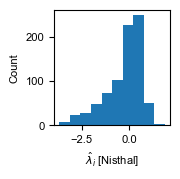

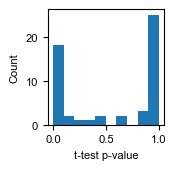

14


In [22]:
# histogram of lambda values
plt.rcParams["figure.figsize"] = (1.5,1.5)

plt.hist (np.ndarray.flatten (ddG_cp))
plt.xlabel (r'$\hat \lambda_i$ [Nisthal]')
plt.ylabel ('Count')
plt.show ()

# t-test for deviation of lambda values from bulk
pvalues_lambda = np.zeros (npos)
for i in range (npos) :
    ddG_i = cp.deepcopy (ddG_cp)
    ddG_i[i,:] = np.nan
    all_gs = ddG_i[~np.isnan (ddG_i)]
    
    pvalues_lambda[i] = scipy.stats.ttest_ind (all_gs, ddG_cp[i,:][~np.isnan (ddG_cp[i,:])],
                                               equal_var=False, alternative='greater').pvalue
    

# and plot
plt.hist (pvalues_lambda)
plt.xlabel ('t-test p-value')
plt.ylabel ('Count')
plt.show ()

# fdr
fdr_lambda = scipy.stats.false_discovery_control (pvalues_lambda[~np.isnan (pvalues_lambda)])
fdr_lambda_thres = np.nanmax (pvalues_lambda[~np.isnan (pvalues_lambda)][fdr_lambda < .1])
print (np.sum (pvalues_lambda < fdr_lambda_thres))

In [23]:
plt.rcParams["figure.figsize"] = (4,1.5)

fig, axs = plt.subplots (1, 2, sharey=True)

axs[0].scatter (n0_sing, residuals,
                s=10, color='lightgray', edgecolor='black', linewidth=.01)
axs[0].set_xscale ('log')
axs[0].set_ylabel ('Residuals')
axs[0].set_xlabel (r'$\hat N_{i}^0$')


axs[1].scatter (np.nanmean (n0_doub, axis=0), residuals,
             s=10, color='lightgray', edgecolor='black', linewidth=.01)
axs[1].set_xscale ('log')
axs[1].set_xlabel (r'$\bar N_{i,\cdot}^0$')

if save :
    plt.savefig (os.path.join (outdir, 'reads_vs_residuals.pdf'), bbox_inches='tight')
    plt.close ()
else :
    plt.show ()

/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_4166/379599958.py:12: RuntimeWarning: Mean of empty slice
  axs[1].scatter (np.nanmean (n0_doub, axis=0), residuals,


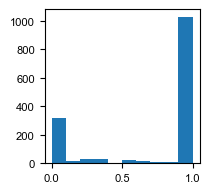

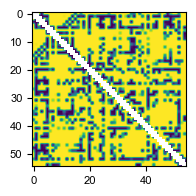

In [24]:
# compute enrichment
Pb, Estat = compute_enrichment (Pvals, alpha=alpha_geom, nAA=nAA, symmetric=True)

# BH procedure
fdrps = scipy.stats.false_discovery_control (Pb[np.triu_indices (npos, k=1)], method='bh')

# back to matrix
FP = np.zeros_like (Pb)
FP[np.triu_indices (npos, k=1)] = fdrps
FP += np.transpose (FP)
np.fill_diagonal (FP, np.nan)

# plot
plt.rcParams["figure.figsize"] = (2,2)

plt.hist (fdrps)
plt.show ()

plt.imshow (FP)

In [25]:
# make the symmetric D matrix
Dsym  = Dmat + np.transpose (Dmat)

# now just store sign
Dsign = np.zeros_like (Dsym)
Dsign[Dsym < 0] = -1
Dsign[Dsym > 0] = 1
Dsign[Pvals > alpha_geom] = np.nan
Dsign[np.isnan (Dsym)] = np.nan

# compute the average sign per pair
avgSign = np.zeros ((npos, npos)) * np.nan
for i in range (npos) :
    for j in range (i+1,npos) :
        avgSign[i,j] = avgSign[j,i] = np.nanmean (Dsign[i*nAA:(i*nAA + nAA),:][:,j*nAA:(j*nAA + nAA)])

# find contacts and nearby things
C5 = np.zeros_like (Df)
C8 = np.zeros_like (Df)

C5[Df <= 5] = 1
C8[np.logical_and (Df > 5, Df <= 8)] = 1

/var/folders/38/f4j79l017855c4b93219m3bh0000gp/T/ipykernel_4166/2427309396.py:15: RuntimeWarning: Mean of empty slice
  avgSign[i,j] = avgSign[j,i] = np.nanmean (Dsign[i*nAA:(i*nAA + nAA),:][:,j*nAA:(j*nAA + nAA)])


In [26]:
# plot all values with BH p-value <= .2
fdr_thres = .01
#avgSign[FP > fdr_thres] = np.nan

maxval = np.nanmax (np.abs (avgSign))
ntests = np.sum (~np.isnan (Pb)) / 2

# spectral color map
spec = mpl.colormaps['Spectral']
norm = plt.Normalize(-1, 1)

In [27]:
# enlarge distance matrix
bigDist = np.zeros ((L,L))
for i in range (npos) :
    bigDist[(i*nAA):(i*nAA + nAA),:] = np.reshape (np.repeat (Df[i,:], nAA**2), (nAA, L), order='F')

In [28]:
plt.rcParams["figure.figsize"] = (4,3)

# set 0s to minimum value in Pb not equal to 0
Pb_0 = cp.deepcopy (Pb)
Pb_0[Pb == 0] = np.nanmin (Pb[Pb != 0])


fig, axs = plt.subplots (1, 2, width_ratios=[3,1],
                         sharey=False, constrained_layout=True)

# create empty canvas
Cnon = cp.deepcopy (C5)
Cnon[~np.isnan (C5)] = np.nan
axs[0].imshow (Cnon)

# <8A
x, y = np.where ( C8 == 1 )
for i in range (len (x)) :
    axs[0].add_patch( Rectangle((y[i]-.5, x[i]-.5), 1, 1, fill=True,
                            color='lightgray', alpha=0.4, lw=.5))# label=r'$\leq 5\AA$')    
# <5A
x, y = np.where ( C5 == 1 )
for i in range (len (x)) :
    axs[0].add_patch( Rectangle((y[i]-.5, x[i]-.5), 1, 1, fill=True,
                            color='lightgray', lw=.5))# label=r'$\leq 5\AA$')

# fdr .1
x, y = np.where (FP <= fdr_thres)
for i in range (len (x)) :
    x_i = x[i]
    y_i = y[i]
    axs[0].scatter (y_i, x_i, marker='o', edgecolor='black',
                    linewidth=.2, color=spec( norm (avgSign[x_i, y_i])),
                    s=(-np.log10 (Pb_0[x_i,y_i]))**(.75))

# fdr .01
x, y = np.where (np.logical_and (FP > fdr_thres, FP <= .1))
for i in range (len (x)) :
    x_i = x[i]
    y_i = y[i]
    axs[0].scatter (y_i, x_i, marker='o', color=spec( norm (avgSign[x_i, y_i])),
                    linewidth=.2, s=(-np.log10 (Pb_0[x_i,y_i]))**(.75))

# Create the figure
ticklocs   = np.arange (3, npos+1, 5)
axs[0].set_xticks (ticklocs, xpos[ticklocs], fontsize=6)
axs[0].set_yticks (ticklocs, xpos[ticklocs], fontsize=6)
axs[0].tick_params (length=2, labelsize=6, pad=1)

axs[0].set_xlabel (protein + r' position $i$', labelpad=2 )
axs[0].set_ylabel (protein + r' position $j$', labelpad=2 )

bplot = axs[1].boxplot (list (reversed (foldinglist)), 
                        flierprops={'markersize': .25},
                        boxprops={'linewidth': .25},  whiskerprops={'linewidth': .25},
                        capprops={'linewidth': .25}, 
                        patch_artist=True, vert=False)
axs[1].axvline (x=0, linestyle='--', color='gray', linewidth=.5, zorder=0)
axs[1].set_yticks (np.flip (np.arange (2, npos+1, 5)), labels=xpos[np.arange (3,npos,5)],
                   rotation=0, fontsize=6)
axs[1].yaxis.tick_right()
axs[1].yaxis.set_label_position("right")
axs[1].tick_params (length=2, labelsize=6, pad=1)


colors = ['lightgray'] * len (foldinglist)
for i in range (npos) :
    if np.flip (pvalues_lambda)[i] < fdr_lambda_thres :
        colors[i] = 'dimgray'
# fill with colors
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
    
# Customize the median line
for median in bplot['medians']:
    median.set(color='black', linewidth=.25)

axs[1].set_ylabel ('GB1 position $j$', labelpad=1)
axs[1].set_xlabel (r'$\hat \lambda_i^{fold}$', labelpad=1)
axs[1].set_position([.78, 0.089, 0.15, 0.8975]) 

if save :
    plt.savefig (os.path.join (outdir, 'dij_improved.svg'),
                 format='svg', dpi=600, bbox_inches='tight', transparent=True)
    plt.close ()
else :
    plt.show ()

In [29]:
false_positive = True
dthres = 8
if false_positive :
    # False positives
    FalseMat = 1.* np.logical_and (Pvals <= alpha, bigDist > dthres)
    FalseMat[np.isnan (Pvals)] = np.nan

    TotMat = 1. * (bigDist > dthres)
    TotMat[np.isnan (Pvals)] = np.nan
    
else :
    # False positives
    FalseMat = 1.* np.logical_and (Pvals <= alpha, bigDist <= dthres)
    FalseMat[np.isnan (Pvals)] = np.nan

    TotMat = 1. * (bigDist <= dthres)
    TotMat[np.isnan (Pvals)] = np.nan

In [30]:
nbins = 12
ybins = np.logspace (np.log10 (np.nanmin (ysing)), np.log10 (np.nanmax (ysing)), nbins)
ebins = np.linspace (np.nanmin (ddG_cp), np.nanmax (ddG_cp), nbins)
ybins = np.append (ybins, np.inf)
ebins = np.append (ebins, np.inf)

FalseMat_sort = FalseMat[np.argsort (ysing),:][:,np.argsort (ysing)]
TotMat_sort   = TotMat[np.argsort (ysing),:][:,np.argsort (ysing)]
FalseMat_g    = FalseMat[np.argsort (np.ndarray.flatten (ddG)),:][:,np.argsort (np.ndarray.flatten (ddG))]
TotMat_g      = TotMat[np.argsort (np.ndarray.flatten (ddG)),:][:,np.argsort (np.ndarray.flatten (ddG))]


# bins for energy and y
g_bins = np.linspace (np.sum (ddG == -4), int (np.sum (~np.isnan (ddG)))+1, nbins)
g_bins = np.append (0, g_bins)
y_bins = np.linspace (0, np.sum (~np.isnan (ysing))+1, nbins+1)

# now compute
Fpbin_y = np.zeros ( (nbins, nbins) )
Fpbin_g = np.zeros_like (Fpbin_y)
for i in range (nbins) :
    low_i  = int (np.floor (g_bins[i]))
    high_i = int (np.floor (g_bins[i+1]))
    l_i    = int (np.floor (y_bins[i]))
    h_i    = int (np.floor (y_bins[i+1]))
    
    for j in range (i,nbins) :
        low_j  = int (np.floor (g_bins[j]))
        high_j = int (np.floor (g_bins[j+1]))
        l_j    = int (np.floor (y_bins[j]))
        h_j    = int (np.floor (y_bins[j+1]))       
        
        # false positive by y singles
        Fpbin_y[i,j] = np.nansum (FalseMat_sort[l_i:h_i,:][:,l_j:h_j])
        Fpbin_y[i,j] /= np.nansum (TotMat_sort[l_i:h_i,:][:,l_j:h_j])

        # energies
        Fpbin_g[j,i] = np.nansum (FalseMat_g[low_i:high_i,:][:,low_j:high_j])
        Fpbin_g[j,i] /= np.nansum (TotMat_g[low_i:high_i,:][:,low_j:high_j])

In [31]:
Fpcp = cp.deepcopy (Fpbin_y)
Fpcp[np.tril_indices (nbins, k=-1)] = np.nan

plt.rcParams["figure.figsize"] = (.95,.95)

fig, axs = plt.subplots ()
myp = axs.imshow (Fpcp, cmap='Blues', vmin=0)# vmax=np.nanmax (Fpbin_g))

axs.yaxis.tick_right()
axs.xaxis.tick_top()
axs.spines['bottom'].set_visible(False)
axs.spines['left'].set_visible(False)
axs.set_yticks (np.arange (0, nbins, 2), labels=np.arange (0, nbins, 2),
                rotation=0, fontsize=6)
axs.set_xticks (np.arange (0, nbins, 2), labels=np.arange (0, nbins, 2),
                rotation=0, fontsize=6)
axs.yaxis.set_label_position ('right')
axs.xaxis.set_label_position ('top')

axs.set_ylabel (r'$\hat Y_j$ bin', labelpad=1, fontsize=7)
axs.set_xlabel (r'$\hat Y_i$ bin', fontsize=7)

axs.tick_params (length=2, labelsize=6, pad=1)

if save :
    plt.savefig (os.path.join (outdir, str (false_positive) + 'y_bins_heatmap.svg'),
                 format='svg', dpi=600, transparent=True, bbox_inches='tight')
    plt.close ()
else :
    plt.show ()

#fig.colorbar (myp, ax=axs, pad=.4, shrink=.5, aspect=15)

In [32]:
Fpcp = cp.deepcopy (Fpbin_y)
Fpcp[np.tril_indices (nbins, k=-1)] = np.nan

plt.rcParams["figure.figsize"] = (2,1.1)

fig, axs = plt.subplots ()
myp = axs.imshow (Fpcp, cmap='Blues', vmin=0)# vmax=np.nanmax (Fpbin_g))

axs.yaxis.tick_right()
axs.xaxis.tick_top()
axs.spines['bottom'].set_visible(False)
axs.spines['left'].set_visible(False)
axs.set_yticks (np.arange (0, nbins, 2), labels=np.arange (0, nbins, 2),
                rotation=0, fontsize=6)
axs.set_xticks (np.arange (0, nbins, 2), labels=np.arange (0, nbins, 2),
                rotation=0, fontsize=6)
axs.yaxis.set_label_position ('right')
axs.xaxis.set_label_position ('top')

axs.set_ylabel (r'$\hat Y_j$ bin', labelpad=1, fontsize=7)
axs.set_xlabel (r'$\hat Y_i$ bin', fontsize=7)

axs.tick_params (length=2, labelsize=6, pad=1)

cbar = fig.colorbar (myp, ax=axs, shrink=0.75, location='right', pad=.3, aspect=13)
cbar.set_label (r'pseudo-$fpr$', size=7, labelpad=5)
cbar.ax.tick_params (labelsize=6, length=3, pad=.5)

if save :
    plt.savefig (os.path.join (outdir, str (false_positive) + 'y_bins_colorbar.svg'),
                 format='svg', dpi=600, transparent=True, bbox_inches='tight')
    plt.close ()
else :
    plt.show ()

#fig.colorbar (myp, ax=axs, pad=.4, shrink=.5, aspect=15)

In [33]:
Fpcp = cp.deepcopy (Fpbin_g)
Fpcp[np.triu_indices (nbins, k=1)] = np.nan

plt.rcParams["figure.figsize"] = (.95,.95)

fig, axs = plt.subplots ()
myp = axs.imshow (Fpcp, cmap='Purples', vmin=0)# vmax=np.nanmax (Fpbin_g))

#axs.yaxis.tick_right()
#axs.xaxis.tick_top()
axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.set_yticks (np.arange (0, nbins, 2), labels=np.arange (0, nbins, 2),
                rotation=0, fontsize=6)
axs.set_xticks (np.arange (0, nbins, 2), labels=np.arange (0, nbins, 2),
                rotation=0, fontsize=6)
#axs.yaxis.set_label_position ('right')
#axs.xaxis.set_label_position ('top')

axs.set_ylabel (r'$\hat \lambda_j^{fold}$ bin', labelpad=0, fontsize=7)
axs.set_xlabel (r'$\hat \lambda_i^{fold}$ bin', labelpad=0, fontsize=7)

axs.tick_params (length=2, labelsize=6, pad=1)

if save :
    plt.savefig (os.path.join (outdir, str (false_positive) + 'fold_bins_heatmap.svg'),
                 format='svg', dpi=600, transparent=True, bbox_inches='tight')
    plt.close ()
else :
    plt.show ()

In [34]:
Fpcp = cp.deepcopy (Fpbin_g)
Fpcp[np.triu_indices (nbins, k=1)] = np.nan

plt.rcParams["figure.figsize"] = (1.1,1.1)

fig, axs = plt.subplots ()
myp = axs.imshow (Fpcp, cmap='Purples', vmin=0)# vmax=np.nanmax (Fpbin_g))

axs.spines['top'].set_visible(False)
axs.spines['right'].set_visible(False)
axs.set_yticks (np.arange (0, nbins, 2), labels=np.arange (0, nbins, 2),
                rotation=0, fontsize=6)
axs.set_xticks (np.arange (0, nbins, 2), labels=np.arange (0, nbins, 2),
                rotation=0, fontsize=6)
axs.set_ylabel (r'$\hat Y_i$ bin', labelpad=0)
axs.set_xlabel (r'$\hat Y_j$ bin', labelpad=0)
axs.tick_params (length=2, labelsize=6, pad=1)

cbar = fig.colorbar (myp, ax=axs, shrink=0.75, location='bottom', pad=.4, aspect=15)
cbar.set_label (r'pseudo-$fpr$', size=7, labelpad=1)
cbar.ax.tick_params (labelsize=6, length=3, pad=.5)

if save :
    plt.savefig (os.path.join (outdir, str (false_positive) + 'fold_bins_colorbar.svg'),
                 format='svg', dpi=600, transparent=True, bbox_inches='tight')
    plt.close ()
else :
    plt.show ()

In [35]:
for t in [10**(-4),10**(-2),.1,.2,.5] :
    print (t)
    print ('all')
    print (np.sum ( np.logical_and (FP < t, Df <= 5)) / np.sum (FP < t))
    print (np.sum ( np.logical_and (FP < t, Df <= 8)) / np.sum (FP < t))
    print ('positive')
    print (np.sum ( np.logical_and (np.logical_and (FP < t, Df <= 5), avgSign > 0)) / np.sum (np.logical_and (FP < t, avgSign > 0)))
    print (np.sum ( np.logical_and (np.logical_and (FP < t, Df <= 8), avgSign > 0)) / np.sum (np.logical_and (FP < t, avgSign > 0)))
    print ('negative')
    print (np.sum ( np.logical_and (np.logical_and (FP < t, Df <= 5), avgSign < 0)) / np.sum (np.logical_and (FP < t, avgSign < 0)))
    print (np.sum ( np.logical_and (np.logical_and (FP < t, Df <= 8), avgSign < 0)) / np.sum (np.logical_and (FP < t, avgSign < 0)))
    print (np.sum (FP < t) /2)
    print ()

0.0001
all
0.4388888888888889
0.6611111111111111
positive
0.5517241379310345
0.8045977011494253
negative
0.3333333333333333
0.5268817204301075
180.0

0.01
all
0.4314516129032258
0.6612903225806451
positive
0.5221238938053098
0.7876106194690266
negative
0.35555555555555557
0.5555555555555556
248.0

0.1
all
0.4031746031746032
0.6285714285714286
positive
0.5107913669064749
0.7553956834532374
negative
0.3181818181818182
0.5284090909090909
315.0

0.2
all
0.38622754491017963
0.6107784431137725
positive
0.48299319727891155
0.7278911564625851
negative
0.31016042780748665
0.5187165775401069
334.0

0.5
all
0.36363636363636365
0.5782828282828283
positive
0.46060606060606063
0.696969696969697
negative
0.2943722943722944
0.4935064935064935
396.0



In [36]:
print (1. - np.nansum (residuals**2) / np.nansum ( (yrank - np.nanmean (yrank))**2))
print (scipy.stats.spearmanr (yrank[~np.isnan (yrank)], rrank[~np.isnan (yrank)]))

0.9823730252944648
SignificanceResult(statistic=0.9911865126472325, pvalue=0.0)


In [37]:
plt.rcParams["figure.figsize"] = (1.2,1.5)

fig, ax = plt.subplots ()

# reload Nisthal data
ddG = np.loadtxt ( os.path.join ('../data/GB1/', 'ddG_nisthal.csv'))[1:,:]

# make a copt
ddG_cp = cp.deepcopy (ddG)
ddG_cp[ddG == -4] = np.nan

maxval = np.nanmax (np.abs (ddG[ddG != -4]))
print (maxval)

ax.scatter (yrank[np.isnan (np.ndarray.flatten (ddG))],
            rrank[np.isnan (np.ndarray.flatten (ddG))],
            color='white', s=5, edgecolor='black', linewidth=.1, label='missing')
ax.scatter (yrank[np.ndarray.flatten (ddG) == -4],
            rrank[np.ndarray.flatten (ddG) == -4], #np.nanmean (R, axis=0),
            marker='x', color='dimgray', label='qual.', linewidth=.5, s=2.5)
myplot = ax.scatter (yrank, rrank, #np.nanmean (R, axis=0),
                     c=np.ndarray.flatten (-ddG_cp), cmap='coolwarm',
                     vmin=-maxval, vmax=maxval, s=5,
                     edgecolor='black', linewidth=0.1)
# colorbar
cbar = fig.colorbar (myplot, ax=ax,
              shrink=0.75, location='top')
cbar.set_label (r'$\hat \lambda_i^{fold}$', size=7, labelpad=5)
cbar.ax.tick_params (labelsize=6, length=3, pad=.5)

ax.set_xticks (np.arange (0,np.nanmax (yrank),250),
               np.array (np.arange (0,np.nanmax (yrank),250), dtype=int))
ax.set_yticks (np.arange (0,np.nanmax (yrank),250),
                   np.array (np.arange (0,np.nanmax (yrank),250), dtype=int))

ax.tick_params (length=2, labelsize=6, pad=1)
ax.set_xlabel (r'$\hat R_{i}$', labelpad=0)
ax.set_ylabel (r'Rank of $\bar R_{\cdot,i}$', labelpad=0)
ax.legend (frameon=False, handletextpad=.1,loc='upper left', fontsize=6)

if save :
    plt.savefig ( os.path.join (outdir, 'fig6_c.svg'),
                  format='svg', bbox_inches='tight', dpi=600, transparent=True)
    plt.close ()
else :
    plt.show ()


3.694


In [38]:
# new copy of nisthal
ddG_cp = cp.deepcopy (-ddG)

# give random values to qualitative points
ddG_4 = cp.deepcopy (-ddG)
ddG_4[ddG_4 != 4] = np.nan
ddG_4[ddG_4 == 4] = (4.25 + np.abs (np.random.normal (0,.2,np.sum (ddG_cp ==4))))
ddG_cp[ddG_cp == 4] = np.nan

In [39]:
plt.rcParams["figure.figsize"] = (1.5,1.5)

# flatten energies
ddg_singles = np.ndarray.flatten (ddG)

# 
y_sig  = cp.deepcopy (residuals[np.logical_and (ddg_singles > -4, ~np.isnan (residuals))])
g_vals = ddg_singles[np.logical_and (ddg_singles > -4, ~np.isnan (residuals))]

# fit linear regression
reg     = LinearRegression().fit (-g_vals.reshape (-1,1), y_sig)
xs      = np.linspace (-np.nanmin (ddG), -np.nanmax (ddG[ddG != -4]),20)
ypred_x = reg.predict (xs.reshape (-1,1))

# variance explained
y_pred = reg.predict (-g_vals.reshape (-1,1))
R2 = 1. - np.sum ((y_sig - y_pred)**2) / np.sum ((y_sig - np.nanmean (y_sig))**2)
print ('R2: ' + str (R2))

R2: 0.25839023767059766


In [40]:
# plot residuals as a function of Nisthal folding energy
fig, axs = plt.subplots (1, 2, width_ratios=[4,1], sharey=True)

myp = axs[0].scatter (ddG_cp, residuals, 
             s=5, c=np.sum (Pvals <= alpha, axis=0),
             cmap='rocket_r',
             edgecolor='black', linewidth=0.05)
axs[0].plot (xs, ypred_x, linestyle='dashed', color='black', linewidth=.5)

cbar = fig.colorbar (myp, ax=axs[0], shrink=.75,
                     label='# signif. $p$-values', location='top')
cbar.set_label (r'# signif. $p$-values', size=7, labelpad=5)
cbar.ax.tick_params (labelsize=6, length=3, pad=.5)

axs[0].set_xlabel (r'$\hat \lambda_i^{fold}$', labelpad=0)
axs[0].set_ylabel ('Residuals', labelpad=0)
axs[0].annotate (r'$R^2=$' + str (np.round (R2, 2)), (-1.75,-225), fontsize=6)

axs[1].scatter (ddG_4, residuals, c=np.sum (Pvals <= alpha, axis=0),
                cmap='rocket_r', vmax=np.nanmax (np.sum (Pvals <= alpha, axis=0)),
                s=5, edgecolor='black', linewidth=0.05)
axs[1].set_position([.71, 0.1115, 0.15, 0.6145]) 
axs[1].set_xlim ( (np.nanmin (ddG_4)-.2, np.nanmax (ddG_4)+.2) )
axs[1].yaxis.tick_right()
axs[1].set_xticklabels([])
axs[1].set_xticks ([])

for i in range (2) :
    axs[i].tick_params (length=2, labelsize=6, pad=1)

if save :
    plt.savefig ( os.path.join (outdir, 'nisthal_residuals_two.svg'),
                 format='svg', dpi=600, transparent=True, bbox_inches='tight')
    plt.close ()
else :
    plt.show ()

In [41]:
plt.rcParams["figure.figsize"] = (1.2,1.5)

# calculate false positive rate
false_positives = np.sum ( np.logical_and (Pvals <= alpha, bigDist > dthres), axis=0 )

# wildtype line
pwt = 1. / (1. + np.exp (gb_wt) * (1. + np.exp (gf_wt)))
lambda_fs = np.linspace (np.nanmin (energies_singles[:,0]), np.nanmax (energies_singles[:,0]), 50)
lambda_bs = -np.log ( (1 + np.exp (lambda_fs + gf_wt))) + np.log ( (1. / pwt) - 1. )

fig, ax = plt.subplots ()

# max residual
maxval = np.nanmax (np.abs (residuals))

# otwinowski energies
myp = plt.scatter (energies_singles[:,0] + gf_wt, energies_singles[:,1] + gb_wt,
             s=(1 + false_positives/np.nanmean (false_positives))**1.5,
             c=residuals, cmap='Spectral',
             vmin=-maxval, vmax=maxval,
             edgecolor='black', linewidth=0.05)

# colorbar
cbar = fig.colorbar (myp, ax=ax, shrink=0.75, location='top')
cbar.ax.tick_params (labelsize=6, length=3, pad=.5)
cbar.set_label ('Residuals', size=7)

# wt
plt.scatter (gf_wt, gb_wt, label='wt',
             marker='o', color='white', s=5, edgecolor='black', linewidth=.5, zorder=5)
# wt cline
plt.plot (lambda_fs + gf_wt, lambda_bs, label=r'$Y_{wt}$',
          linestyle='dashed', color='black', linewidth=.5)

# legend
plt.legend (frameon=False, loc='upper left', fontsize=6, handlelength=1)
ax.set_xlabel (r'$\hat \Lambda^{fold}$ [Otwin.]', labelpad=0)
ax.set_ylabel (r'$\hat \Lambda^{bind}$ [Otwin.]', labelpad=0)
ax.set_xticks (np.arange (-20, np.nanmax (energies_singles[:,0]) + gf_wt, 10),
               np.array (np.arange (-20, np.nanmax (energies_singles[:,0]) + gf_wt, 10), dtype=int))
ax.tick_params (length=2, labelsize=6, pad=1)

# save
if save :
    plt.savefig ( os.path.join (outdir, 'fig6_e.svg'),
                 format='svg', dpi=600, transparent=True, bbox_inches='tight')
    plt.close ()
else :
    plt.show ()
